In [1]:
import os
os.environ["OMP_NUM_THREADS"] = '16'
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pybnesian as pbn
import pickle
import scikit_posthocs as sp
from statds.no_parametrics import friedman, hommel

In [2]:
methodLocDict = {
    '$k$NNCIT': './results/real/knncit',
    'MRCIT': './results/real/mrcit',
    'MMCIT': './results/real/mmcit',
    'CGIT': './results/real/cgit',
    'DGCIT': './results/real/dgcit',
    'HC': './results/real/hillclimbing'
}

In [3]:
def preprocess_dataset(filename):
    df = pd.read_csv('./datasets/real/' + filename)

    cat_data = df.select_dtypes('object').astype('str').astype('category')
    for c in cat_data:
        df = df.assign(**{c: cat_data[c]})

    # induce as categoricals numeric columns with less than 10 values
    index_low_cats = np.where(df.select_dtypes('number').nunique() < 10)[0]
    for integer_cat_column in index_low_cats:
        df[df.columns[integer_cat_column]] = df[df.columns[integer_cat_column]].astype(
            'str').astype('category')

    float_data = df.select_dtypes('number').astype('float64')
    for c in float_data:
        df = df.assign(**{c: float_data[c]})

    node_children_blacklist = []
    for source in df.columns:
        for target in df.columns:
            if source != target and df[target].dtype == 'category' and df[source].dtype == 'float64':
                
                node_children_blacklist.append(
                    [source, target])
                
    return df, node_children_blacklist

## Parameter Learning

In [4]:
def find_pdag_nodetypes(pdag, df, node_children_blacklist):
    dag = None

    arcs = [[u,v] for u,v in pdag.arcs()]
    for v1, v2 in arcs:
        if pdag.has_arc(v1, v2) and pdag.has_arc(v2, v1):
            pdag.remove_arc(v1, v2)
            pdag.remove_arc(v2, v1)
            pdag.add_edge(v1, v2)

    try:
        dag = pdag.to_dag()
        pdagfalse = pbn.PartiallyDirectedGraph(df.columns)
        for arc in dag.arcs():
            pdagfalse.add_arc(arc[0], arc[1])
        spbn = pbn.SemiparametricBNType().spbn_from_pdag(df, pdagfalse, node_children_blacklist)

    except:
        spbn = pbn.SemiparametricBNType().spbn_from_pdag(df, pdag, node_children_blacklist)
    return spbn

In [ ]:
# compute metrics and store results
try:
    results = pd.read_csv('./results/real/results_params.csv')
except:
    results = pd.DataFrame(columns=['method', 'ds_name', 'LOGL'])

In [ ]:
entry = []
directory = os.fsencode('./datasets/real')
filenames = [x for x in enumerate(sorted(os.listdir(directory)))]

for i, filename in filenames:
    ds_name = os.fsdecode(filename)
    print(ds_name, flush=True)
    df, node_children_blacklist = preprocess_dataset(ds_name)
    score = pbn.CVLikelihood(df, k=4)
    
    for method in methodLocDict.keys():
        if len(results.loc[(results['method'] == method) & (results['ds_name'] == ds_name)]) > 0:
                continue
        try:
            
            with open(methodLocDict[method]+ ds_name[:-4]+'.pkl', "rb") as f:
                learned_graph = pickle.load(f)
            
            if method != 'HC':
                learned_spbn = find_pdag_nodetypes(learned_graph, df, node_children_blacklist)
            else:
                # already an hspbn
                learned_spbn = learned_graph

            # cross-validated likelihood over the dataset
            slogl = score.score(learned_spbn)
                
            results = pd.concat([results, pd.DataFrame([[method, ds_name, slogl]], columns = ['method', 'ds_name', 'LOGL'])])
            results.to_csv('./results/real/results_params.csv', index=False)

        except Exception as e:
            print("Error in", ds_name, method)
            print(e, flush=True)


haberman.csv


#### Critical difference diagram 

In [4]:
def create_symmetric_matrix(comparisons_df):
    # Extract all unique methods from comparisons
    methods = set()
    for comp in comparisons_df['Comparison']:
        a, b = comp.split(' vs ')
        methods.update([a, b])
    methods = sorted(methods)  # Sort for consistent order
    
    # Initialize matrix with 1.0 on diagonal and 0.0 for first row/column
    n = len(methods) + 1  # +1 for index column
    mat = np.zeros((n, n))
    np.fill_diagonal(mat, 1.0)
    
    # Create index names
    index_names = ['index'] + methods
    
    # Create mapping from comparison to adjusted p-value
    pvalue_map = {}
    for _, row in comparisons_df.iterrows():
        a, b = row['Comparison'].split(' vs ')
        pvalue_map[(a, b)] = row['Adjusted p-value']
        pvalue_map[(b, a)] = row['Adjusted p-value']  # Symmetric
    
    # Fill the matrix
    for i, method1 in enumerate(methods, start=1):
        for j, method2 in enumerate(methods, start=1):
            if i != j:  # Skip diagonal
                mat[i, j] = pvalue_map.get((method1, method2), 0.0)
    
    # Set first row and column to 0 (except diagonal)
    mat[0, 1:] = 0.0
    mat[1:, 0] = 0.0
    
    # Create DataFrame
    return pd.DataFrame(mat, index=index_names, columns=index_names)

In [5]:
directory = os.fsencode('./datasets/real')
filenames = [x for x in enumerate(sorted(os.listdir(directory)))]
datasets = []
for i, filename in filenames:
    ds_name = os.fsdecode(filename)
    df, _ = preprocess_dataset(ds_name)
    datasets.append([ds_name, df])

In [17]:
len(datasets)

39

In [6]:
valid_ds_names = []
cont_ratio = []
for ds_name, df in datasets:
    if len(df) > 700:
        valid_ds_names.append(ds_name)

In [19]:
valid_ds_names

['529_pollen.csv',
 'Abalone.csv',
 'Airfoil_Self-Noise.csv',
 'Blood_Transfusion_Service_Center.csv',
 'Combined_Cycle_Power_Plant.csv',
 'Concrete_Compressive_Strength.csv',
 'Page_Blocks_Classification.csv',
 'Rice_(Cammeo_and_Osmancik).csv',
 'banana.csv',
 'vehicle.csv',
 'vowel.csv']

In [7]:
results = pd.read_csv('./results/real/results_params.csv')
results_700 = results.loc[results['ds_name'].isin(valid_ds_names), :]

pivoted_df = results.pivot_table(
    index=['ds_name'],
    columns='method',
    values='LOGL'
).reset_index(drop=True)
pivoted_df = pivoted_df.reset_index(drop=False)

pivoted_df_700 = results_700.pivot_table(
    index=['ds_name'],
    columns='method',
    values='LOGL'
).reset_index(drop=True)
pivoted_df_700 = pivoted_df_700.reset_index(drop=False)


In [8]:
pivoted_df = pivoted_df.loc[~(pivoted_df.isna().sum(axis=1) != 0), :]
pivoted_df_700 = pivoted_df_700.loc[~(pivoted_df_700.isna().sum(axis=1) != 0), :]


In [28]:
lengths = []
for ds_name, df in datasets:
    lengths.append(len(df))

np.median(lengths)

np.float64(403.0)

#### Critical difference diagrams

In [9]:
color_map = {
    '$k$NNCIT': 'tab:red',
    'MRCIT':    'tab:blue',
    'HC':       'tab:green',
    'MMCIT':    'tab:purple',
    'CGIT':     'tab:orange',
    'DGCIT':    'tab:cyan'
}

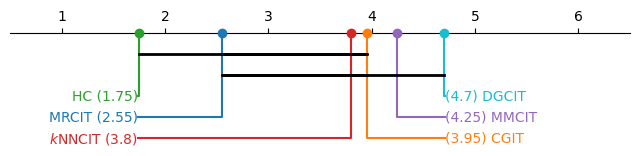

In [10]:
rankings, statistic, p_value, critical_value, hypothesis = friedman(pivoted_df, alpha = 0.05, minimize=False, verbose=False)
num_cases = pivoted_df.shape[0]
results, _ = hommel(ranks=rankings, num_cases=num_cases, alpha=0.05, control = None, type_rank = "Friedman", verbose=False)
plt.close()
plt.figure(figsize=(8, 1.5), dpi=100)

sp.critical_difference_diagram(rankings, create_symmetric_matrix(results), label_fmt_left='{label} ({rank:.3g})', label_fmt_right='({rank:.3g}) {label}',color_palette=color_map)

plt.xlim(0.5,6.5)
plt.savefig(f'./results/real/CDD_LOGLREAL_1.eps', format = 'eps', bbox_inches='tight')

rankings, statistic, p_value, critical_value, hypothesis = friedman(pivoted_df_700, alpha = 0.05, minimize=False, verbose=False)
num_cases = pivoted_df_700.shape[0]
results, _ = hommel(ranks=rankings, num_cases=num_cases, alpha=0.05, control = None, type_rank = "Friedman", verbose=False)
plt.close()
plt.figure(figsize=(8, 1.5), dpi=100)

sp.critical_difference_diagram(rankings, create_symmetric_matrix(results), label_fmt_left='{label} ({rank:.3g})', label_fmt_right='({rank:.3g}) {label}',color_palette=color_map)

plt.xlim(0.5,6.5)
plt.savefig(f'./results/real/CDD_LOGLREAL_2.eps', format = 'eps', bbox_inches='tight')